# Các hướng dẫn cơ bản về TensorFlow
## MaSSP 2017, Computer Science

Để sử dụng TensorFlow, chúng ta cần hiểu cách TensorFlow:

- Biểu diễn các phép tính dưới dạng graph
- Chạy graph trong Session
- Biễu diễn dữ liệu dưới dạng tensor 
- Lưu trạng thái với Variable 
- Sử dụng feeds và fetches để nhập và xuất dữ liệu ra khỏi các operation

TensorFlow là một hệ thống ngôn ngữ lập trình, trong đó ta biểu diễn các tính toán dưới dạng <b>graph</b>. Các nodes trong graph được gọi là các <b>operations</b>.

Một operation có thể nhận 0 hoặc nhiều hơn 0 Tensor, thực hiện một số tính toán, và tạo ra 0 hoặc nhiều hơn 0 Tensor.

<b>Tensor</b> là một typed multi-dimensional array. Ví dụ, một nhóm các hình ảnh có thể được biểu diễn bằng một 4-D array gồm các số thực. Bốn chiều của array này là [batch, height, width, channels], tương ứng với số hình ảnh, chiều cao của một ảnh, độ rộng của một ảnh, và số channel. Số channel của một ảnh tùy thuộc vào tính chất của ảnh, ví dụ ảnh đen trắng thì số channel là 1 do mỗi điểm ảnh chỉ cần 1 giá trị để thể hiện độ đen-trắng, còn ảnh màu RGB thì cần 3 channels để thể hiện độ đỏ-xanh lá-xanh dương tương ứng...

TensorFlow sử dụng graph để thể hiện toàn bộ quá trình tính toán. Để thực hiện tính toán trong graph, graph phải được chạy trong một <b>Session</b>. Một Session sẽ đưa các operation trong graph vào CPU hoặc GPU để thực hiện chúng.

## 1. Xây dựng TensorFlow graph đơn giản nhất
Đầu tiên chúng ta import tensorflow và viết tắt nó là <i>tf</i>.

In [1]:
import tensorflow as tf

Dùng lệnh $get\_default\_graph()$ để thu được graph có sẵn.

In [2]:
graph = tf.get_default_graph()

Như đã đề cập, mỗi node trong graph là một operation. Hàm $get\_operations()$ sẽ trả về các operations có trong graph.

In [3]:
graph.get_operations()

[]

Lúc này graph chưa có operation nào cả, nhưng ta sẽ khởi tạo một hằng số với giá trị $1.0$.

In [4]:
input_value = tf.constant(1.0)

Hằng số này nằm trong một node, hay một operation trong graph.

In [6]:
operations = graph.get_operations()
operations

>Từ output ta thấy được đây là một Operation được định nghĩa tại đây: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/framework/ops.py 

Ta có thể dùng $node\_def$ để thấy rõ hơn cấu trúc của operation này.

In [7]:
operations[0].node_def

name: "Const"
op: "Const"
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "value"
  value {
    tensor {
      dtype: DT_FLOAT
      tensor_shape {
      }
      float_val: 1.0
    }
  }
}

Chúng ta cũng có thể đánh giá "input_value" theo cách thông thường, nhưng sẽ chỉ thu được những thông tin sau.

In [7]:
input_value

<tf.Tensor 'Const:0' shape=() dtype=float32>

>Bạn hãy thử tìm xem kết quả trên thu được nhờ hàm nào trong https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/framework/ops.py?  

><b>Trả lời:</b>

Kết quả cho thấy "input_value" là một hằng số, 32-bit float tensor không có chiều, nhưng kết quả không cho ta biết giá trị của hằng số này là gì. Để đánh giá "input_value" và nhận được giá trị số của nó, chúng ta cần đến một "session".

In [8]:
sess = tf.Session()
sess.run(input_value)

1.0

Lưu ý, ngoài $Session()$, chúng ta sẽ sử dụng $InteractiveSession()$ rất nhiều trong chương trình, vì với $InteractiveSession$, chúng ta không cần viết $sess.run(input\_value)$, mà dùng cách ngắn gọn hơn là $input\_value.eval()$.

In [9]:
sess = tf.InteractiveSession()
input_value.eval()

1.0

Hãy nhớ đóng session lại cuối chương trình!

In [10]:
sess.close()

## 2. Xây dựng TensorFlow neuron
Trong phần này, chúng ta sẽ mô phỏng lại một neuron đơn giản. Neuron này chỉ có 2 tham số cần tìm và cả 2 đều là số thực, đó là $weight$ và $bias$. Neuron sẽ nhận một giá trị input, và xuất ra một giá trị output theo công thức $$output = weight * input + bias$$

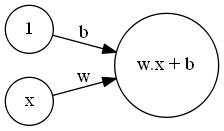

In [3]:
from IPython.core.display import Image 
Image(filename="../../images/Lab2/a_simple_neuron.png")

Neuron sẽ bắt đầu với giá trị $weight$ và $bias$ bất kì. Chúng ta sẽ cho neuron giá trị của $input$, và $expected\_output$ mong muốn tương ứng với $input$ này. Với giá trị $weight$ và $bias$ ban đầu, neuron áp dụng công thức tính ra $output$, và tất nhiên sẽ có sai số với $expected\_output$.

Để giúp neuron điều chỉnh giá trị $weight$ và $bias$ cho phù hợp (sao cho $output$ của neuron sẽ gần hơn với $expected\_output$), chúng ta sẽ cung cấp cho neuron một hàm tính sai số. Sai số càng lớn khi $output$ của neuron càng xa với $expected\_output$ mong muốn, và neuron sẽ thay đổi $weight$ và $bias$ nhiều hơn khi sai số càng lớn.

Hiển nhiên, $weight$ và $bias$ sẽ biến thiên tùy vào $input$ và $expected\_output$ trong quá trình học. Do đó, ta sẽ sử dụng biến TensorFlow ($tf.Variable$ class) cho chúng. Code của $tf.Variable$ class: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/variables.py.

Đầu tiên, khởi tạo biến này với một giá trị $weight$ ban đầu, giả sử là $0.8$.

In [8]:
weight = tf.Variable(0.8)
weight

Hãy xem so với khởi tạo một hằng số, việc khởi tạo một biến thêm vào graph bao nhiêu operations?

In [9]:
for op in graph.get_operations():
    print(op.name)

Const
Variable/initial_value
Variable
Variable/Assign
Variable/read


>Vậy là có 4 operations tương ứng với việc có thêm biến này, bên cạnh operation khởi tạo hằng số "Const" ở phần 1.
* Variable/initial_value
* Variable
* Variable/Assign
* Variable/read

Tương tự, ta khởi tạo biến $bias$ với giá trị ban đầu bất kì, giả sử là $0.5$.

In [10]:
bias = tf.Variable(0.5)
bias

In [11]:
for op in graph.get_operations():
    print(op.name)

Const
Variable/initial_value
Variable
Variable/Assign
Variable/read
Variable_1/initial_value
Variable_1
Variable_1/Assign
Variable_1/read


Với $input\_value$ $1.0$ từ phần 1 và $weight$, $bias$ vừa khởi tạo, ta đã sẵn sàng thêm vào graph một operation tính toán thật sự khi tính $output$.

In [12]:
output = weight * input_value + bias

Hãy viết code để biết được 2 loại operation mới nhất nào vừa được thêm vào graph.

In [14]:
#answer:

Bạn có thể đoán được đoạn code có mục đich gì không?

In [20]:
for op in graph.get_operations():
    print("Operation name: {}".format(op.name))
    for op_input in op.inputs:
        print("\tOp input: {}".format(op_input))

<b>Trả lời:</b>

Bản thân operation nhân có thông tin về các input của nó (cũng là những operation khác trong graph). Tưởng tượng với số lượng operation tăng lên, sẽ rất khó nhớ được mối quan hệ giữa các operation. [TensorBoard graph visualization](https://www.tensorflow.org/how_tos/graph_viz/) là một công cụ giúp ta hình dung graph trong TensorFlow.

Nhưng trước khi sử dụng TensorBoard, hãy thử tính kết quả của phép nhân trên.

In [22]:
sess = tf.InteractiveSession()
sess.run(output)

Thay vì nhận được kết quả, chúng ta lại gặp lỗi này:

"FailedPreconditionError (see above for traceback): Attempting to use uninitialized value Variable"

Phép nhân này cần có biến $weight$. Mặc dù chúng ta đã khởi tạo biến này, giá trị của nó vẫn chưa được gán trong session hiện tại. Hàm $tf.global\_variables\_initializer()$ sẽ làm nhiệm vụ init tất cả các biến trong graph (trong trường hợp này chỉ có một biến là $weight$).

In [23]:
init = tf.global_variables_initializer()

Hàm này cũng trả về một operation, nên đừng quên dùng session để thực hiện operation này!

In [24]:
sess.run(init)

Cuối cùng ta có thể chạy operation "output".

In [25]:
sess.run(output)

1.3

Đây là kết quả tính hợp lý của $output = weight * input + bias = 0.8 * 1.0 + 0.5 = 1.3$.

## 3. Dùng TensorBoard để phân tích graph

TensorBoard là một công cụ hữu ích giúp thể hiện mối quan hệ của các operation trong graph cũng như xem thông tin của từng operation. Ngoài ra TensorBoard còn nhiều chức năng khác như vẽ đồ thị, chúng ta sẽ tìm hiểu song song với các bài thực hành tiếp theo.

Đầu tiên, ta cần đến FileWrite, cùng với tên của thư mục ta sẽ lưu dữ liệu của graph vào (ví dụ "Lab2_Tutorial1").

In [22]:
file_writer = tf.summary.FileWriter("Lab2_Tutorial1", sess.graph)

Bây giờ bạn hãy tạm rời Jupyter và dùng command line để chạy TensorBoard.

In [41]:
## sau khi đã "activate tensorflow":

#(tensorflow) D:\MaSSP\track_2>tensorboard --logdir=Lab2_Tutorial1
#WARNING:tensorflow:Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
#WARNING:tensorflow:Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
#Starting TensorBoard b'39' on port 6006
#(You can navigate to http://10.0.0.5:6006)

Thư mục "Lab2_Tutorial1" sẽ được tạo ra nếu chưa tồn tại, và đường link http://10.0.0.5:6006 có thể được truy cập từ trình duyệt web là nơi ta có thể nhìn thấy graph, trông tương tự như sau:

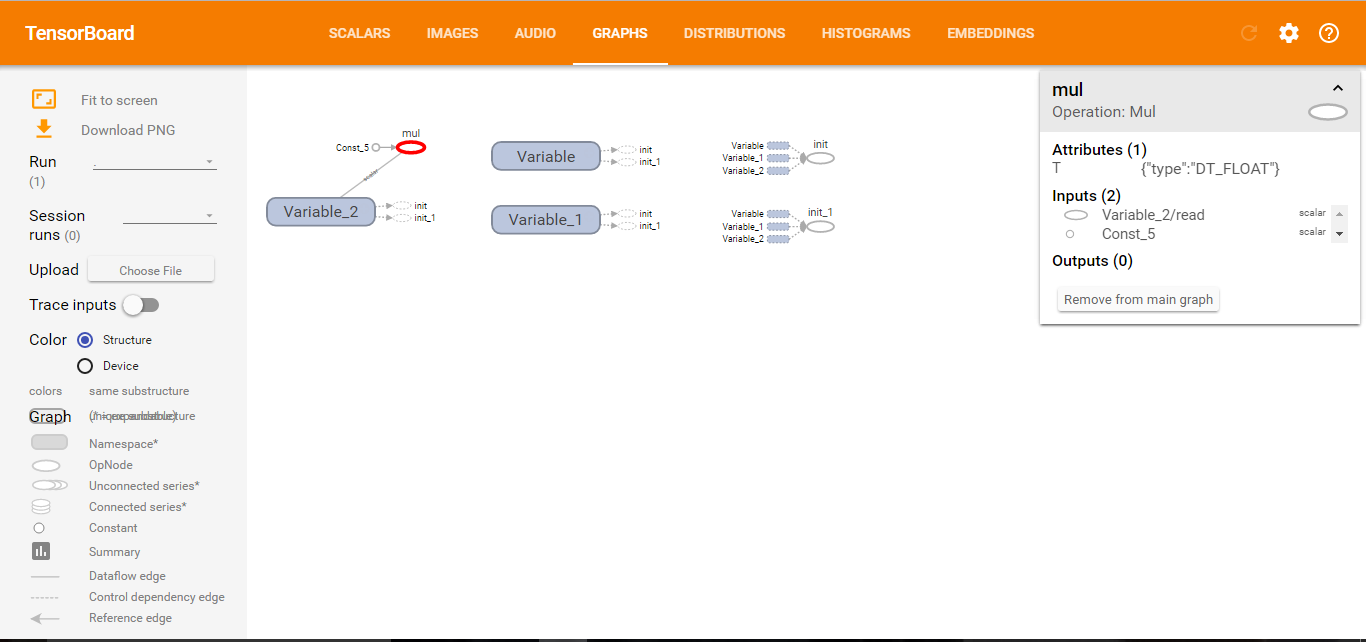

In [3]:
Image(filename='../../images/Lab2/log_simple_graph.png')

Ta nhận thấy rằng operation có tên khác với tên biến trong Python (ta không thấy có chữ "output", "input_value" trong graph, thay vào đó là "Const_1", "Variable_2" hoặc tương tự). Tuy nhiên ta có thể đặt tên các operation này để phân biệt chúng dễ dàng hơn trong graph.

In [29]:
x = tf.constant(1.0, name="input")
w = tf.Variable(0.8, name="weight")
y = tf.mul(w, x, name="output")

Hãy viết lại graph lần nữa.

In [30]:
tf.summary.FileWriter("Lab2_Tutorial1", sess.graph)

Và khởi động lại TensorBoard with "Lab2_Tutorial1", and refresh trang http://10.0.0.5:6006.

In [ ]:
#(tensorflow) D:\MaSSP\track_2>ls
#... Lab2_Tutorial1

#(tensorflow) D:\MaSSP\track_2>tensorboard --logdir=Lab2_Tutorial1
#Starting TensorBoard b'39' on port 6006
#(You can navigate to http://10.0.0.5:6006)

Và tên các operation xuất hiện trong graph.

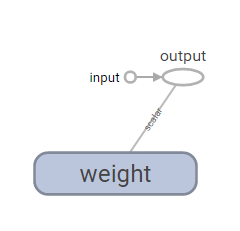

In [36]:
Image(filename='../../images/Lab2/named_vars.png')

Ngoài cách đặt tên biến, ta còn có thể sử dụng hàm $tf.name\_scope()$ để nhóm các operation lại với nhau. Việc nhóm các operation tương tự giúp biểu diễn cách graph phức tạp dễ dàng hơn và hiểu cách thành phần của quá trình tính toán rõ ràng hơn.

In [33]:
with tf.name_scope("a_simple_neuron") as scope:
    x = tf.constant(1.0)
    w = tf.Variable(0.8, name="weight")
    y = tf.mul(w, x)

In [34]:
tf.summary.FileWriter("Lab2_Tutorial1", sess.graph)

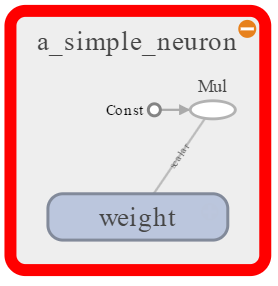

In [37]:
Image(filename='../../images/Lab2/a_simple_neuron_scope.png')

## 4. Train neuron - Linear Regression
Quay lại với neuron đơn giản của chúng ta với chỉ 2 thông số là $weight$ và $bias$ và các thông số này có giá trị ban đầu lần lượt là là $0.8$ và $0.5$. Với $input\_value$ là $1.0$, neuron tính giá trị $output$ là $1.3$. Tuy nhiên, giả sử $expected\_output$ chúng ta mong muốn lại là $1.6$, thay vì $0.8$, ta cần giúp neuron biết: 1) giá trị $output$ nó tính được là chưa chuẩn (lý do là vì $weight$ và $bias$ chưa chuẩn!), và 2) chỉ cho neuron biết cách điều chỉnh $weight$ và $bias$ để giảm sai số giữa $output$ neuron tính được và $expected\_output$ thực tế.


### 4.1 Hàm sai số
Ta cần định nghĩa một hàm sai số để tính được độ lệch của $output$ và $expected\_output$. Trong trường hợp này chúng đều là 2 số thực, nên các tính sai số hiển nhiên nhất là hiệu giữa 2 số. Ta dùng $cost$ để chỉ sai số:
$$cost = expected\_output - output$$
Tuy nhiên như đã giải thích trong bài giảng, thông thường ta sẽ sử dụng hàm sai số least squares hơn là chỉ tính hiệu.
$$cost = (expected\_output - output)^2$$

In [46]:
y_expected = tf.constant(1.6, name="expected_output")

In [48]:
with tf.name_scope("cost_function") as scope:
    cost = (y_expected - output)**2

Ta có thể đánh giá $cost$ với session hiện tại.

In [32]:
cost.eval()

0.090000041

>Kết quả này có hợp lý không?

><b>Trả lời:</b>

### 4.2 Điều chỉnh tham số
Từ giá trị hiện tại của $cost$, ta cần điều chỉnh $weight$ và $bias$. Hiển nhiên nếu sai số $cost$ càng lớn thì ta nên thay đổi càng nhiều $weight$ và $bias$.

Trong bài giảng, ta đã biết đến cách dùng Gradient Descent để điều chỉnh tham số dựa vào đạo hàm của $cost$. TensorFlow cung cấp hàm $GradientDescentOptimizer()$ cho việc này, lấy $learning_rate$ là giá trị thể hiện tốc độ học nhanh hay chậm của quá trình học. Nếu tốc độ học quá lớn, khả năng cao ta sẽ không đạt được giá trị nhỏ nhất của sai số. Tốc độ học quá chậm lại dẫn đến việc quá trình học quá lâu, qua nhiều bước mà sai số vẫn lớn.

Để bắt đầu, ta sẽ thử với tốc độ học là $0.025$. Và định nghĩa một bước học là quá trình điều chỉnh $weight$ và $bias$ dựa vào sai số $cost$, sử dụng Gradient Descent Optimizer của TensorFlow với tốc độ học $0.025$.
>Gradient Descent Optimizer: https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer

In [2]:
with tf.name_scope("train_step") as scope:
    train_step = tf.train.GradientDescentOptimizer(0.025).minimize(cost)

Chúng ta sẽ điều chỉnh thông số 100 lần (100 bước học). Hàm $tf.summary.scalar$ giúp ta biết được các biến thay đổi thế nào trong quá trình học.

In [84]:
file_writer = tf.summary.FileWriter("Lab2_Tutorial1", sess.graph)
sess.run(tf.global_variables_initializer())

# Tạo các đồ thị thể hiện sự biến thiên của weight, bias, cost, và output
summary_weight = tf.summary.scalar('weight', weight)
summary_bias = tf.summary.scalar('bias', bias)
summary_cost = tf.summary.scalar('cost', cost)
summary_y = tf.summary.scalar('output', output)

# Thực hiện quá trình học
for i in range(100):
    # Tính và log các giá trị hiện tại của weight, bias, cost, và output
    summaries = sess.run([summary_weight, summary_bias, summary_cost, summary_y])
    for summary in summaries:
        file_writer.add_summary(summary, i)
        
    # Gọi bước học tiếp theo
    sess.run(train_step)

>Hãy sử dụng TensorBoard để trả lời các câu hỏi sau:
- Giá trị cuối cùng của weight, bias, và cost?
- Giá trị cuối cùng của output có hợp lý không?
- Đến khoảng bước nào thì cost giảm không đáng kể?
- Tại sao sau bước này thì giá trị của weight, bias, cost, và output không thay đổi nhiều?

><b>Trả lời:</b>

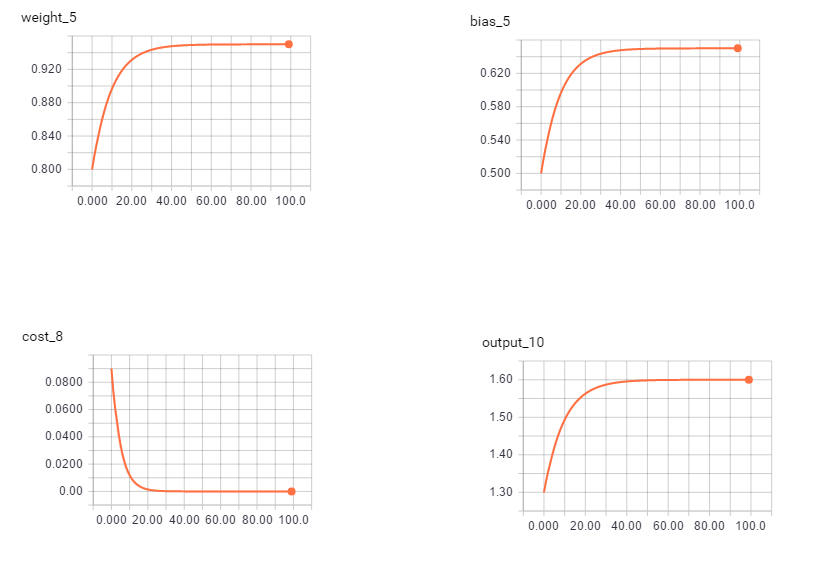

In [53]:
Image(filename='../../images/Lab2/a_simple_neuron_one_data_point.png')

>Hãy thay đổi learning_rate và lặp lại các bước trên
- learning_rate = 0.4
- learning_rate = 0.5
- learning_rate = 0.001
- learning_rate = 0.00001

>Kết quả cuối cùng của $weight$ và $bias$ sẽ thế nào nếu ta thay đổi giá trị ban đầu của chúng?

><b>Trả lời:</b>


### 4.3 Kết luận
Chúng ta vừa xây dựng một neuron đơn giản bằng TensorFlow với 2 thông số $weight$ và $bias$. Với một cặp giá trị $(input, expected_output)$ cho sẵn, neuron đã biết cách học và tự điều chỉnh $weight$ và $bias$ sao cho $output$ mà neuron tính được càng gần với $expected_output$. Số bước học và sai số của $output$ phụ thuộc nhiều vào tốc độ học, hàm sai số, và optimizer.

Trong lab tiếp theo, chúng ta sẽ cho neuron học dựa trên nhiều cặp giá trị $(input, expected_output)$ khác nhau, thay vì một cặp $(0.8, 1.6)$ như trên (vô số nghiệm thỏa mãn cho hệ phương trình 2 ẩn, 1 phương trình). Ví dụ:

$x = [ 0.69818965,  0.03600568,  0.38004098,  0.54867665,  0.77140362,
        0.14180334,  0.79793543,  0.62246678,  0.83741225,  0.35568029,
        0.50941244,  0.35629587,  0.30729451,  0.79838528,  0.15345702,
        0.51881063,  0.36676517,  0.37895616,  0.32881045,  0.05895714,
        0.88217842,  0.98285312,  0.77286511,  0.63268851,  0.21075436,
        0.38381641,  0.719504  ,  0.04006471,  0.68526506,  0.43028117,
        0.18095321,  0.57466665,  0.25489683,  0.73533942,  0.75925032,
        0.98209417,  0.33751455,  0.14896683,  0.19882339,  0.17733215,
        0.2921697 ,  0.16130439,  0.59056498,  0.54991829,  0.58480317,
        0.76033344,  0.89624513,  0.21760338,  0.31829866,  0.14802099]$
        
$y = [  8.08547501,   1.39327444,   4.85622766,   6.49788741,
         8.79965048,   2.45163163,   9.04843162,   7.25194377,
         9.44707918,   4.60137047,   6.17227011,   4.64572935,
         4.11230941,   9.09402535,   2.54751761,   6.24180985,
         4.7271495 ,   4.8372221 ,   4.32824772,   1.63130206,
         9.84149227,  10.88639699,   8.80739298,   7.35862825,
         3.16449296,   4.92269619,   8.24764643,   1.43612695,
         7.87799429,   5.32425571,   2.835729  ,   6.79168412,
         3.58991078,   8.40987512,   8.60362513,  10.89046363,
         4.43198107,   2.5277707 ,   3.00061629,   2.79709814,
         3.95075638,   2.63390985,   6.96654605,   6.50899219,
         6.88854502,   8.70440389,  10.08665379,   3.21517247,
         4.21780963,   2.50088878]$

Mặt khác mỗi input có thể không phải là một số thực như trên (thể hiện 1 thuộc tính), mà có nhiều thuộc tính và input khi đó sẽ được biếu diễn bởi 1 vector.

Hiển nhiên với nhiều cặp giá trị $(input, expected\_output)$, khả năng lớn ta sẽ không tìm được một giá trị chính xác của $weight$ và $bias$ thỏa mãn cho tất cả các cặp giá trị. Điều này không phải là vấn đề lớn, vì thứ nhất, ta luôn tìm được nghiệm sao cho sai số giữa tất cả $output$ và $expected\_output$ là bé nhất, và thứ hai, nếu mục đích của quá trình học là để dự đoán gần đúng $expected\_output$ của các $input$ mới trong test set mà neuron chưa bao giờ gặp, thì việc sai số quá bé trong train set là dấu hiệu của overfitting - neuron "học thuộc lòng" train set và khó dự đoán đúng $expected\_output$ của test set.